<a href="https://colab.research.google.com/github/Barikko/Yandex.Practicum-Projects/blob/main/%D0%9F%D1%80%D0%B8%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_%D1%80%D0%B5%D1%88%D0%B5%D0%BD%D0%B8%D0%B9_%D0%B2_%D0%B1%D0%B8%D0%B7%D0%BD%D0%B5%D1%81%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект: Принятие решений в бизнесе

Цель проекта: анализ крупного интернет-магазина для увеличения выручки. 

Данные: файл "hypothesis.csv" с гипотезами, наделёнными параметрами для их приоритизации. Датасеты "orders.csv" и "visitors.csv" с данными о покупках, выручке, пользователе, дате заказа и его группе.

План работы:

1. Приоритизация гипотез с примененнием фреймворков ICE/RICE.
2. А/В анализ, состоящий из: 
- Построения графиков для визуалиации различий между группами
- Подсчёт перцентилей для опредедения границы аномальных пользователей
- Подсчёт статистической значимости различий между "сырыми" и обработанными данными
- Принятие решение по результам теста.

# Загрузка данных и подготовка их к анализу

In [51]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import scipy.stats as stats

In [52]:
hypothesis, orders, visitors = (
    pd.read_csv('/content/hypothesis.csv'),
    pd.read_csv('/content/orders.csv'), 
    pd.read_csv('/content/visitors.csv'),)

## Предобработка hypothesis

In [53]:
hypothesis.info()
hypothesis.columns = hypothesis.columns.str.lower()
print(hypothesis.head(10))
pd.options.display.max_colwidth = 130

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
                                                                                                     hypothesis  \
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный

Названия колонок переведены в нижний регистр.

## Предобработка orders

In [54]:
orders.info()
orders['date'] = pd.to_datetime(orders['date']).dt.date 
orders.columns = ['transaction_id','visitor_id','date','revenue','group']
print(orders.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
   transaction_id  visitor_id        date  revenue group
0      3667963787  3312258926  2019-08-15     1650     B
1      2804400009  3642806036  2019-08-15      730     B
2      2961555356  4069496402  2019-08-15      400     A
3      3797467345  1196621759  2019-08-15     9759     B
4      2282983706  2322279887  2019-08-15     2308     B


In [55]:
print(orders.isna().sum())
orders.duplicated().sum()

transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


0

Дата приведена к нужному формату, колонки переименованы, дубликатов не обнаружено.

## Предобработка visitors

In [56]:
visitors.info()
print(visitors.head(5))
print(orders.isna().sum())
visitors['date'] = pd.to_datetime(visitors['date']).dt.date
orders.duplicated().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
         date group  visitors
0  2019-08-01     A       719
1  2019-08-02     A       619
2  2019-08-03     A       507
3  2019-08-04     A       717
4  2019-08-05     A       756
transaction_id    0
visitor_id        0
date              0
revenue           0
group             0
dtype: int64


0

Дата приведена к нужному формату, пропусков и дубликатов нет.

## Удалим посетителей, принадлежащих к обеим группам


In [57]:
delet=np.intersect1d(orders.query('group == "A"')['visitor_id'].unique(), orders.query('group == "B"')['visitor_id'].unique())
orders = orders.query('visitor_id not in @delet')

# Приоритизация гипотез

##    Применение фреймворка ICE для приоритизации гипотез.
    

In [58]:
hypothesis['ICE']=(hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis','ICE']].sort_values(by = 'ICE', ascending = False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы: 8, 0, 7, наименее: 5, 3, 4.

## Применение фреймворк RICE для приоритизации гипотез.

In [59]:
hypothesis['RICE']=(hypothesis['reach']*hypothesis['impact']*hypothesis['confidence'])/hypothesis['efforts']
display(hypothesis[['hypothesis','RICE']].sort_values(by = 'RICE', ascending = False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы: 7, 2, 0, наименее: 1, 5, 4.

## Как изменилась приоритизация гипотез при применении RICE вместо ICE и почему?

In [60]:
display(hypothesis)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.333333,40.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.000000,4.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.000000,56.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125000,9.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.000000,3.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.333333,4.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.000000,40.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.200000,112.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.200000,16.2


Гипотеза 8 опустилась на несколько позиций, в то время как гипотеза 7 поднялась на первое место, так как параметр Reach 7 гипотезы равен 10, что выше всех остальных, а параметр Reach 8 гипотезы равен 1.

# Анализ A/B-теста

## График кумулятивной выручки по группам.

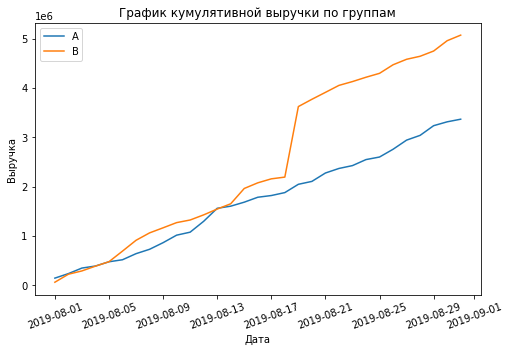

In [61]:
# создаем массив уникальных пар значений дат и групп теста
plt.figure(figsize=(8, 5))
datesGroups = orders[['date','group']].drop_duplicates()
datesGroups['date'] = pd.to_datetime(datesGroups['date']).dt.date 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'],\
visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'],\
orders['group'] == x['group'])]\
.agg({'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' : 'nunique', 'revenue' : 'sum'}), axis=1)\
.sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors'] 

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')
# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.legend()
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.xticks(rotation = 20);

"Синяя" группа стабильно хуже, "красная" лучше и имеет несколько всплесков, самый крупный которых был 18.08. В этот день была самая большая выручка из-за аномально дорогого заказа.

## График кумулятивного среднего чека по группам.

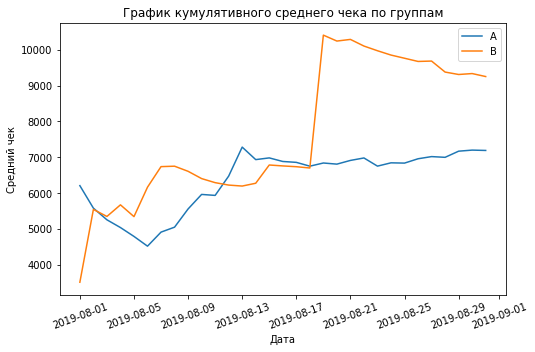

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend() 
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.xticks(rotation = 20);

Средний чек синей группы А был гораздо ниже до 13.08, после которого произошёл всплеск, но после у группы В произошёл аномально большой всплеск 18.08, из-за которого средний чек стал на треть больше.

## График относительного изменения кумулятивного среднего чека группы B к группе A. 

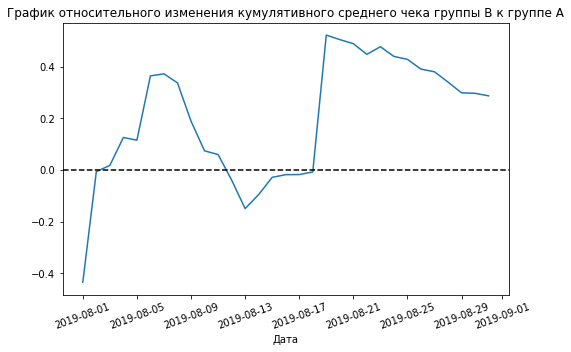

In [63]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(8, 5))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation = 20);

Во многих точках график скачет, что говорит крупных заказах, после 18 числа проиходит самый большой скачок, после которого идёт медленное снижение. Кумулятивный средний чек группы B стабильно выше другой группы.

##  График кумулятивного среднего количества заказов на посетителя по группам. 

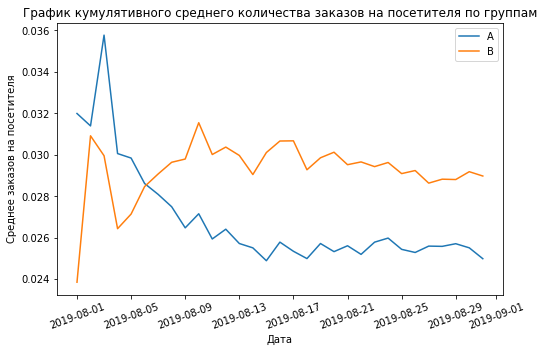

In [64]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']
plt.figure(figsize=(8, 5))
# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']
# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее заказов на посетителя')
plt.xticks(rotation = 20);

Конверсии обеих групп со временем падают примерно на 5%, но группа А заметно ниже группы В.


##     График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

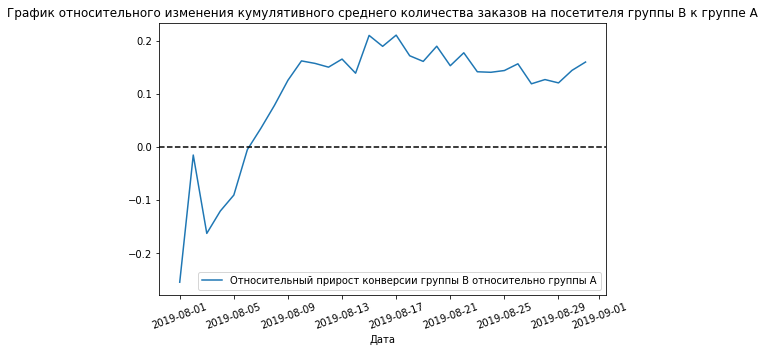

In [65]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
plt.figure(figsize=(8, 5))                              
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.xticks(rotation = 20);

Сначала среднее количество заказов на посетителя группы B было меньше, чем у группы А, но потом среднее выросло на примерно 15%.

##   Точечный график количества заказов по пользователям.

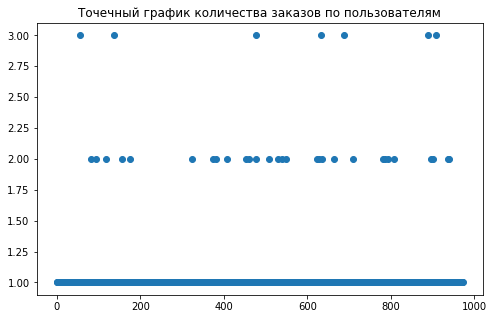

In [66]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['visitor_id', 'orders']
plt.figure(figsize=(8, 5))
x_value = pd.Series(range(0,len(ordersByUsers['orders'])))
plt.title('Точечный график количества заказов по пользователям')
plt.scatter(x_value, ordersByUsers['orders']);

Большинство пользователей делают 1 заказ, но многие также делают 2 или 3 заказа.

## 95-й и 99-й перцентили количества заказов на пользователя.

In [67]:
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[1. 2.]


Аномальными пользователями можно счиать пользователей, совершивших более 2 покупок.

##    Точечный график стоимостей заказов.

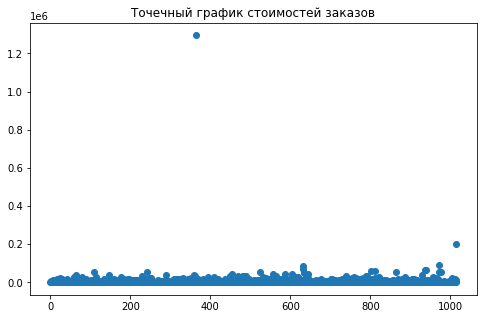

In [68]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(8, 5))
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, orders['revenue']);

Все заказы стоят примерно одинаково, но встречаются и аномально дорогие заказы.

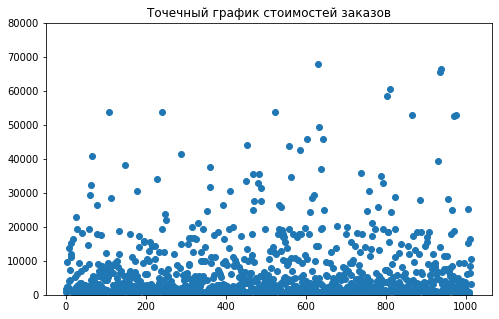

In [69]:
#Тот же график, ограниченный по y, чтобы осмотреть основную часть без выбросов
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(8, 5))
plt.ylim(0,80000)
plt.title('Точечный график стоимостей заказов')
plt.scatter(x_values, orders['revenue']);

##  95-й и 99-й перцентили стоимости заказов.

In [70]:
print(np.percentile(orders['revenue'], [95, 99]))

[26785. 53904.]


Не более 5% заказов дороже 26785 у.е. и не более 1% дороже 53904. Границей аномальных значений будет 95 перцентиль.

##   Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным.
 

H0 - Статистической значимости различий в среднем количестве заказов на посетителя между группами нет.

Н - Статистическая значимость различий в среднем количестве заказов на посетителя между группами есть.

In [71]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

In [72]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitor_id', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitor_id', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

alpha = .05

p_value=stats.mannwhitneyu(sampleA, sampleB)[1]

print("p-value: {0:.3f}".format(p_value))

print("Различие в среднем количестве заказов: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

if p_value < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

p-value: 0.011
Различие в среднем количестве заказов: 0.160
Отвергаем нулевую гипотезу


p-value (0.011) < 0.05. Значит, нулевую гипотезу отвергаем, различия в среднем количестве заказов на посетителя между группами есть. Относительный выигрыш группы B равен 16% 

## Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным.

H0 - Статистической значимости различий в среднем чеке заказа между группами нет.

Н - Статистическая значимость различий в среднем чеке заказа между группами есть.

In [73]:
p_value1=stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]

print('p-value: {0:.3f}'.format(p_value1))
print('Различие в среднем чеке: {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

if p_value1 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

p-value: 0.829
Различие в среднем чеке: 0.287
Не получилось отвергнуть нулевую гипотезу


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Средний чек группы B выше среднего чека группы A почти на 30%. Поскольку относительное различие среднего чека между сегментами составляет ~26%, наблюдаемые различия не являются значимыми при таком уровне значимости, а следовательно были получены случайно. 

##   Статистическая значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [74]:
x=np.percentile(orders['revenue'], 95)
y=np.percentile(ordersByUsers['orders'], 99)

In [75]:
#Находим количество аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > y]['visitor_id'],
        ordersByUsersB[ordersByUsersB['orders'] > y]['visitor_id'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > x]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])

568     113298937
1099    148427295
928     204675465
33      249864742
684     358944393
Name: visitor_id, dtype: int64
58


In [76]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitor_id'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

p_value2 =stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]

print('{0:.3f}'.format(p_value2))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

if p_value2 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

0.012
0.182
Отвергаем нулевую гипотезу


Результаты практически не изменились (0.016 и 0.174 против 0.011 и 0.160). Различия в среднем количестве заказов на посетителя между группами есть.

##  Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [77]:
p_value3 = stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]

print(
    '{0:.3f}'.format(p_value3))

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

if p_value3 < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print(
        'Не получилось отвергнуть нулевую гипотезу'
    ) 

0.646
-0.048
Не получилось отвергнуть нулевую гипотезу


p-value незначительно уменьшилось(0.727 против 0.829). А разница между сегментами сократилась с 0.287 до -0.034. Аномалии сильно повлияли на результат теста.

# Итог


После предобработки данных были удалены посетители, принадлежавшие к обеим группам. Фреймворком ICE были ФреймворкомRICE.

##   Решение по результатам теста.

1. Есть значимые различия по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;
2. Есть статистически значимое различие по среднему чеку между группами (Чек группы В на 28% выше) по «сырым» данным, после фильтрации аномалий разницы между сегментами практически нет;
3. График различия конверсии между группами сообщает, что результаты группы B лучше группы А на 15%;
4. График различия среднего чека говорит о том, что результаты группы B лучше на от до 20 до 40% в зависимости ото дня, но это было достигнуто аномально большими заказами.

Исходя из обнаруженных фактов, тест следует остановить. Победа за группой В. Различия между группами присутствуют, даже после очистки данных от аномалий, сильно повлиявших на тест.